In [1]:
CUDA_INDEX = 3
NAME = 'GED_IMDBMulti'

In [2]:
import sys
sys.path.insert(0, '../..')
sys.path.insert(0, '../../pyged/lib')

In [3]:
import os
import pickle
import random
import time

import IPython as ipy
import matplotlib.pyplot as plt
import numpy as np
import torch
torch.cuda.set_device(CUDA_INDEX)
torch.backends.cudnn.benchmark = True
import torch.optim
import torch_geometric as tg
import torch_geometric.data
from tqdm.auto import tqdm

from neuro import config, datasets, metrics, models, train, utils, viz
import pyged

from importlib import reload
reload(config)
reload(datasets)
reload(metrics)
reload(models)
reload(pyged)
reload(train)
reload(utils)
reload(viz)

<module 'neuro.viz' from '../../neuro/viz.py'>

In [4]:
outer_test_set = torch.load(f'/data/rishabh/neurosim/final//data/{NAME}/outer_test.pt', map_location='cpu')
queries, targets, lb, ub = outer_test_set

In [5]:
preds = [
    ('NeuroGSim     ', torch.load(f'../preds/{NAME}/outer_pred.pt', map_location='cpu')),
#     ('NeuroGSim-Norm', torch.load(f'../preds/{NAME}/norm_outer_pred.pt', map_location='cpu')),
#     ('NeuroGSim-NN  ', torch.load(f'../preds/{NAME}/nn_outer_pred.pt', map_location='cpu')),
#     ('NeuroGSim-Dual', torch.load(f'../preds/{NAME}/dual_outer_pred.pt', map_location='cpu')),
#     ('NeuroMatch    ', torch.as_tensor(np.load(f'../preds/{NAME}/nm_outer_pred.npy'))),
    ('H2MN-RW       ', torch.as_tensor(np.load(f'../preds/{NAME}/h2mn_rw.npy'))),
    ('H2MN-NE       ', torch.as_tensor(np.load(f'../preds/{NAME}/h2mn_ne.npy'))),
    ('SimGNN        ', torch.as_tensor(np.load(f'../preds/{NAME}/sg_outer_pred.npy')).view(len(queries), len(targets))),
#     ('Branch        ', torch.load(f'../preds/{NAME}/b_outer_pred.pt', map_location='cpu')),
#     ('F2            ', torch.load(f'../preds/{NAME}/f2_outer_pred.pt', map_location='cpu')),
]

In [6]:
from scipy.stats import kendalltau
sed = (lb+ub)/2
gs = torch.tensor([g.num_nodes for g in queries])
hs = torch.tensor([h.num_nodes for h in targets])
for i, (label, pred) in enumerate(preds):
    tmp = []
    for i in range(len(queries)):
        tmp.append(kendalltau(utils.similarity_of_ged(sed[i], gs[i], hs).cpu(),
                              utils.similarity_of_ged(pred[i], gs[i], hs).cpu(),
                              nan_policy='omit')[0])
    tau = sum(tmp)/len(tmp)
    print(f'{tau:.3f}')

0.868
0.805
0.821
0.704


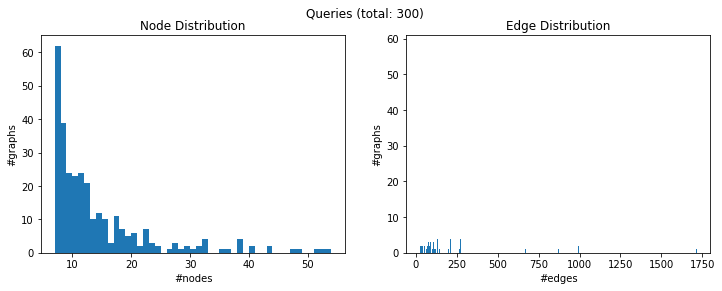

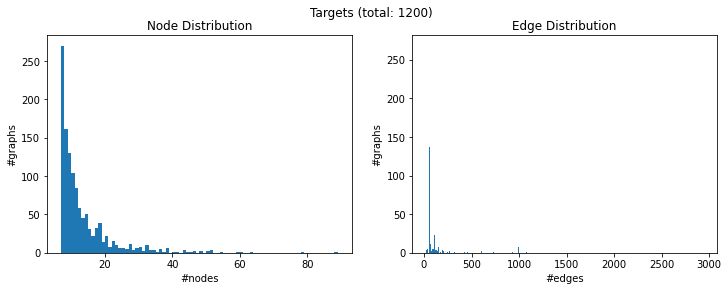

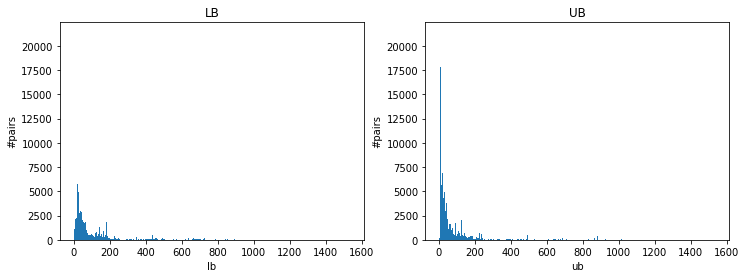

In [7]:
viz.plot_dataset_dist(outer_test_set)

In [8]:
def rank_metrics(fn, lb, ub, preds, ylabel, title, percent=True):
    k = torch.arange(1, 21, 1)
    plt.figure()
    Ys = []
    for label, pred in preds:
        Y = fn(k, lb, ub, pred)
        viz.plot_summary(k, Y, show_std=False, label=label, lim=percent)
        Ys.append((Y, label))
    plt.legend()
    plt.xlabel('k')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    
    for Y, label in Ys:
#         print(f'{label}', end='\n')
        Z = torch.mean(Y, dim=-1)
        for i in [1,5,10,15,20]:
            if percent:
                print(f'{Z[i-1].item()*100:.2f}', end=' / ' if i != 20 else '\n')
            else:
                print(f'{Z[i-1].item():.3f}', end=' / ' if i != 20 else '\n')
#         print()

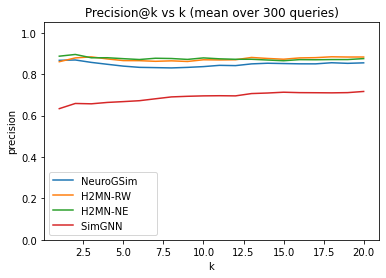

86.67 / 83.87 / 83.63 / 85.11 / 85.45
86.00 / 86.53 / 86.93 / 87.20 / 88.27
88.67 / 87.47 / 87.83 / 86.47 / 87.50
63.33 / 66.73 / 69.50 / 71.27 / 71.63


In [9]:
rank_metrics(metrics.precision_at_k, (lb+ub)/2, (lb+ub)/2, preds,
            'precision', f'Precision@k vs k (mean over {len(queries)} queries)')

In [13]:
from scipy.stats import kendalltau
_, true_sort_idx = torch.sort(utils.similarity_of_ged((lb+ub)/2), dim=-1)
for i, (label, pred) in enumerate(preds):
    _, pred_sort_idx = torch.sort(pred, dim=-1)
    tmp = []
    for i in range(len(queries)):
        tmp.append(kendalltau(((lb+ub)/2)[i], pred[i], nan_policy='omit')[0])
    tau = sum(tmp)/len(tmp)
    print(f'{tau:.3f}')

TypeError: similarity_of_ged() missing 2 required positional arguments: 'gs' and 'hs'

In [11]:
for label, pred in preds:
#     print(f'{label}', end='\n')
    tmp = torch.mean(metrics.kendalls_tau_at_k(torch.tensor([len(targets)]), lb, ub, pred)).item()
    print(f'{tmp*100:.2f}')
#     print()

88.51
88.61
80.99
17.88
20.58


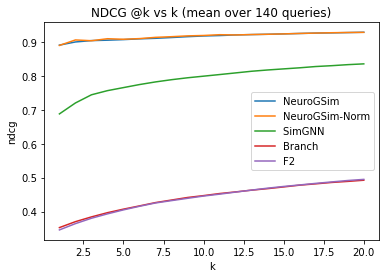

0.891 / 0.908 / 0.918 / 0.925 / 0.929
0.891 / 0.909 / 0.920 / 0.925 / 0.929
0.688 / 0.766 / 0.800 / 0.821 / 0.836
0.352 / 0.407 / 0.447 / 0.473 / 0.492
0.346 / 0.405 / 0.446 / 0.474 / 0.495


In [12]:
rank_metrics(metrics.ndcg_at_k, lb, ub, preds,
            'ndcg', f'NDCG @k vs k (mean over {len(queries)} queries)',
            percent=False)

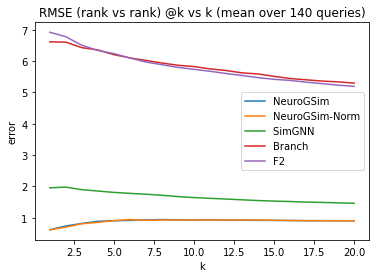

0.621 / 0.907 / 0.932 / 0.918 / 0.905
0.614 / 0.912 / 0.930 / 0.923 / 0.905
1.957 / 1.811 / 1.647 / 1.533 / 1.465
6.614 / 6.206 / 5.826 / 5.514 / 5.299
6.921 / 6.240 / 5.738 / 5.419 / 5.196


In [13]:
rank_metrics(metrics.rmse_at_k, lb, ub, preds,
            'error', f'RMSE (rank vs rank) @k vs k (mean over {len(queries)} queries)',
            percent=False)

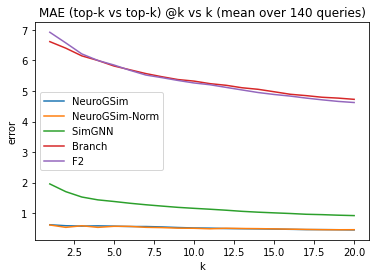

0.621 / 0.576 / 0.516 / 0.480 / 0.452
0.614 / 0.570 / 0.506 / 0.486 / 0.459
1.957 / 1.383 / 1.159 / 1.010 / 0.921
6.614 / 5.817 / 5.323 / 4.974 / 4.726
6.921 / 5.850 / 5.261 / 4.885 / 4.621


In [14]:
rank_metrics(metrics.error_at_k, lb, ub, preds,
            'error', f'MAE (top-k vs top-k) @k vs k (mean over {len(queries)} queries)',
            percent=False)